In [1]:
!pip install pyspark
!pip install nltk
!pip install transformers torch
!pip install pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, explode, split, count, when, udf
from pyspark.sql.types import ArrayType, StringType, FloatType
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from transformers import pipeline

In [4]:
# Download stopwords
nltk.download('stopwords')

# Initialize Spark session
spark = SparkSession.builder.appName("UAQTE_Responses_Analysis").getOrCreate()

# File upload (manual upload)
uploaded = files.upload() # Upload the CSV file
file_name = list(uploaded.keys())[0] # Get the filename dynamically

# Load dataset
df = spark.read.csv(file_name, header=True, inferSchema=True)

# Show raw data
df.show(truncate=False)
# Preprocessing Steps

df = df.withColumn("responses", regexp_replace(col("responses"), r"[^a-zA-Z\s]", ""))
df = df.withColumn("responses", lower(col("responses")))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving UAQTEresponses.csv to UAQTEresponses.csv
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Responses                                                                                                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
# Tokenization
df = df.withColumn("words",split(col("responses"), " "))

# Stopword Removal
stop_words = set(stopwords.words("english"))
additional_stopwords = {"uaqte", "UAQTE", " "} # Customize as needed stop_words.update(additional_stopwords)
def remove_stopwords(words):
  return [word for word in words if word not in stop_words and word != ""]

remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))
df = df.withColumn("filtered_words", remove_stopwords_udf(col("words")))

#Word Frequency Analysis
df_exploded = df.select(explode(col("filtered_words")).alias("word"))
df_exploded = df_exploded.filter(~col("word").isin(additional_stopwords))
word_counts = df_exploded.groupBy("word").count().orderBy(col ("count").desc())
word_counts.show(20)

+-------------+-----+
|         word|count|
+-------------+-----+
|    education|   34|
|      tuition|   34|
|         free|   27|
|    financial|   26|
|         help|   26|
|          one|   24|
|      college|   21|
|       helped|   21|
|       family|   19|
|beneficiaries|   19|
|         able|   19|
|        study|   18|
|      parents|   15|
|     expenses|   15|
|         much|   15|
|       school|   14|
|        helps|   14|
|          lot|   14|
|      studies|   14|
|         also|   12|
+-------------+-----+
only showing top 20 rows



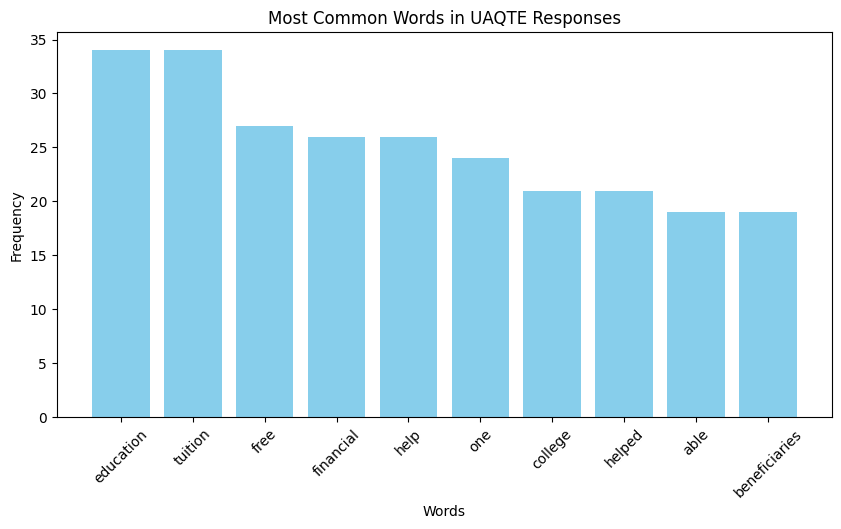

In [7]:

# Convert to Pandas for visualization
word_counts_pd = word_counts.limit(10).toPandas()
# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(word_counts_pd["word"], word_counts_pd["count"], color="skyblue")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in UAQTE Responses")
plt.xticks(rotation=45)
plt.show()

# HYPERPARAMETERS
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english" # Change to another BERT model BATCH_SIZE = 16 # Number of texts processed per batch (increase for speed)
MAX_LENGTH = 512 # Truncate text after 512 tokens
CONFIDENCE_THRESHOLD = 0.75 # If confidence < 0.75, classify as NEUTRAL

In [8]:
# Load BERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=MODEL_NAME)
 # Initializes a Hugging Face pipeline for sentiment analysis.
 # Uses a pretrained BERT model (specified in MODEL_NAME) to analyze text and classify it as POSITIVE or NEGATIVE (and optionally NEUTRAL).
 # Handles tokenization, model inference, and result interpretation internally.
def get_sentiment(text):
  if text:
    result = sentiment_pipeline(text[:MAX_LENGTH], truncation=True)[0] # Limit to max tokens
    label, score = result['label'], result['score']

    # Apply confidence threshold
    if score < CONFIDENCE_THRESHOLD:
      return "NEUTRAL"
    elif label == "POSITIVE":
      return "POSITIVE"
    else:
      return "NEGATIVE"
      return "NEUTRAL"

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [9]:

# Define PySpark UDF for sentiment classification

sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis
df = df.withColumn("sentiment", sentiment_udf(col("responses")))

 # Creates a new column "sentiment" in the DataFrame.
 # Applies the UDF to classify sentiment for each row in the "responses" column.
# Show sentiment results

df.select("responses", "sentiment").show(truncate=False)

df.groupBy("sentiment").count().show()

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|responses                                                                                                                                                                                                                                                                                                                                                                                      |sentiment|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------